In [358]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [359]:
import xwmt
import xarray as xr
import numpy as np
import xgcm

import matplotlib.pyplot as plt

### Simple test experiments

In [377]:
def idealized_diffusion(z):
    return np.sin(2*np.pi*z)

### Case 1: `dz` ~ `dlam`

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

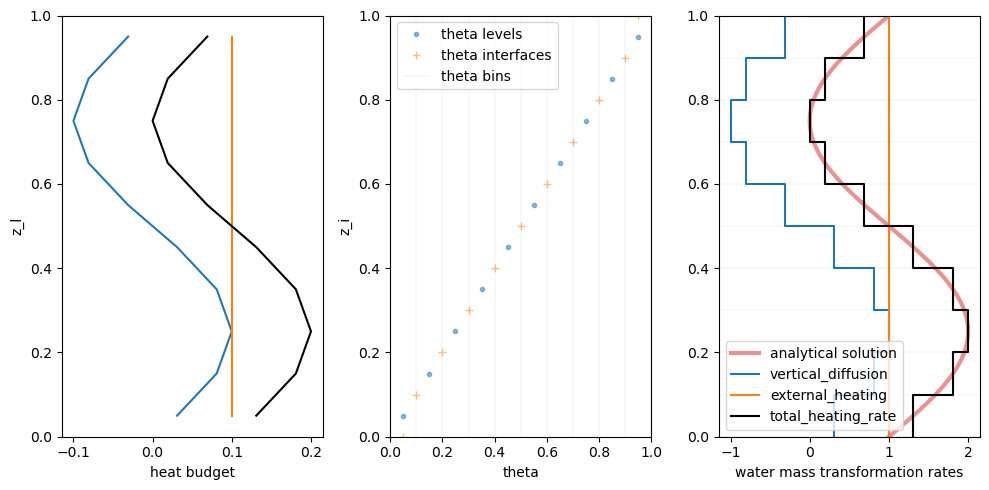

In [382]:
dz = 1.e-1
dlam = 1.e-1
bins = np.arange(0., 1.+dlam, dlam)

def lam_constant_stratification(z):
    return z

def exact_solution(lam):
    return np.sin(2*np.pi*lam) + 1.

ds = xr.Dataset()
ds = ds.assign_coords({
    'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
    'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
})
ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})

budget_dict = {'heat': {
    'lambda': 'theta',
    'lhs': {'tendency':'total_heating_rate'},
    'rhs': {
        'vertical_diffusion':'vertical_diffusion',
        'external_heating':'external_heating'
    }
}, 'salt': {'lambda':'salt', 'rhs': {}, 'lhs': {}}}

ds['vertical_diffusion'] = xr.DataArray(idealized_diffusion(ds.z_l), coords=(ds.z_l,))*ds.dz
ds['external_heating'] = xr.ones_like(ds.vertical_diffusion)*ds.dz
ds['total_heating_rate'] = ds['vertical_diffusion'] + ds['external_heating']

ds['theta'] = xr.DataArray(lam_constant_stratification(ds.z_l.data), coords=(ds.z_l,))

# expand to horizontal dimension and add grid metrics
ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

metrics = {
    ('X',): [], # X distances
    ('Y',): [], # Y distances
    ('Z',): ['dz'], # Z distances
    ('X', 'Y'): ['rA'] # Areas
}
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
    'Z': {'center': 'z_l', 'outer': 'z_i'},
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])

wmt = xwmt.WaterMassTransformations(ds, grid, budget_dict, cp=1., rho_ref=1.)
wmts = wmt.integrate_transformations("temperature", bins=bins, sum_components=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
for wmt in budget_dict['heat']['rhs'].values():
    ds[wmt].plot(y="z_l", label=wmt)
for wmt in budget_dict['heat']['lhs'].values():
    ds[wmt].plot(y="z_l", label=wmt, color="k")
plt.ylim(0, 1)
plt.xlabel("heat budget")
plt.title("")

plt.subplot(1,3,2)
lam = ds['theta']
lam.plot(y="z_l", linewidth=0., alpha=0.5, marker=".", label="theta levels")
lam_i = (
    grid.interp(lam, "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
    .rename(lam.name)
)
lam_i.plot(y="z_i", marker="+", linewidth=0., alpha=0.5, label="theta interfaces")
for b in bins:
    plt.axvline(b, color='k', alpha=0.15, lw=0.25)
plt.axvline(np.nan, color='k', alpha=0.15, lw=0.25, label="theta bins")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("")
plt.legend()
    
plt.subplot(1,3,3)
lam = wmts[wmt].theta
dlam_analytical = 1.e-5
lam_analytical = np.arange(dlam_analytical/2, 1., dlam_analytical)
plt.plot(exact_solution(lam_analytical), lam_analytical, color="C3", ls="-", label="analytical solution", alpha=0.5, lw=3)

for wmt in budget_dict['heat']['rhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, where="pre")
for wmt in budget_dict['heat']['lhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, color="k", where="pre")
for b in bins:
    plt.axhline(b, color='k', alpha=0.15, lw=0.25)
plt.ylim(0, 1)
    
plt.legend()
plt.ylim(0, 1)
plt.xlabel("water mass transformation rates")
plt.tight_layout()

### Case 2: `dz` << `dlam`

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

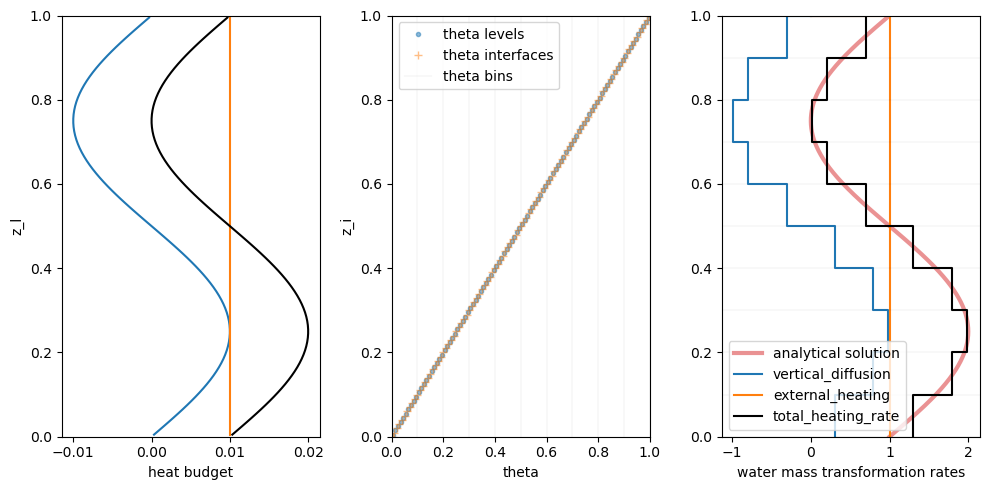

In [383]:
dz = 1.e-2
dlam = 1.e-1
bins = np.arange(0., 1.+dlam, dlam)

def lam_constant_stratification(z):
    return z

def exact_solution(lam):
    return np.sin(2*np.pi*lam) + 1.

ds = xr.Dataset()
ds = ds.assign_coords({
    'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
    'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
})
ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})

budget_dict = {'heat': {
    'lambda': 'theta',
    'lhs': {'tendency':'total_heating_rate'},
    'rhs': {
        'vertical_diffusion':'vertical_diffusion',
        'external_heating':'external_heating'
    }
}, 'salt': {'lambda':'salt', 'rhs': {}, 'lhs': {}}}

ds['vertical_diffusion'] = xr.DataArray(idealized_diffusion(ds.z_l), coords=(ds.z_l,))*ds.dz
ds['external_heating'] = xr.ones_like(ds.vertical_diffusion)*ds.dz
ds['total_heating_rate'] = ds['vertical_diffusion'] + ds['external_heating']

ds['theta'] = xr.DataArray(lam_constant_stratification(ds.z_l.data), coords=(ds.z_l,))

# expand to horizontal dimension and add grid metrics
ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

metrics = {
    ('X',): [], # X distances
    ('Y',): [], # Y distances
    ('Z',): ['dz'], # Z distances
    ('X', 'Y'): ['rA'] # Areas
}
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
    'Z': {'center': 'z_l', 'outer': 'z_i'},
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])

wmt = xwmt.WaterMassTransformations(ds, grid, budget_dict, cp=1., rho_ref=1.)
wmts = wmt.integrate_transformations("temperature", bins=bins, sum_components=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
for wmt in budget_dict['heat']['rhs'].values():
    ds[wmt].plot(y="z_l", label=wmt)
for wmt in budget_dict['heat']['lhs'].values():
    ds[wmt].plot(y="z_l", label=wmt, color="k")
plt.ylim(0, 1)
plt.xlabel("heat budget")
plt.title("")

plt.subplot(1,3,2)
lam = ds['theta']
lam.plot(y="z_l", linewidth=0., alpha=0.5, marker=".", label="theta levels")
lam_i = (
    grid.interp(lam, "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
    .rename(lam.name)
)
lam_i.plot(y="z_i", marker="+", linewidth=0., alpha=0.5, label="theta interfaces")
for b in bins:
    plt.axvline(b, color='k', alpha=0.15, lw=0.25)
plt.axvline(np.nan, color='k', alpha=0.15, lw=0.25, label="theta bins")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("")
plt.legend()
    
plt.subplot(1,3,3)
lam = wmts[wmt].theta
dlam_analytical = 1.e-5
lam_analytical = np.arange(dlam_analytical/2, 1., dlam_analytical)
plt.plot(exact_solution(lam_analytical), lam_analytical, color="C3", ls="-", label="analytical solution", alpha=0.5, lw=3)

for wmt in budget_dict['heat']['rhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, where="pre")
for wmt in budget_dict['heat']['lhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, color="k", where="pre")
for b in bins:
    plt.axhline(b, color='k', alpha=0.15, lw=0.25)
plt.ylim(0, 1)
    
plt.legend()
plt.ylim(0, 1)
plt.xlabel("water mass transformation rates")
plt.tight_layout()

### Case 3: `dz` >> `dlam`

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

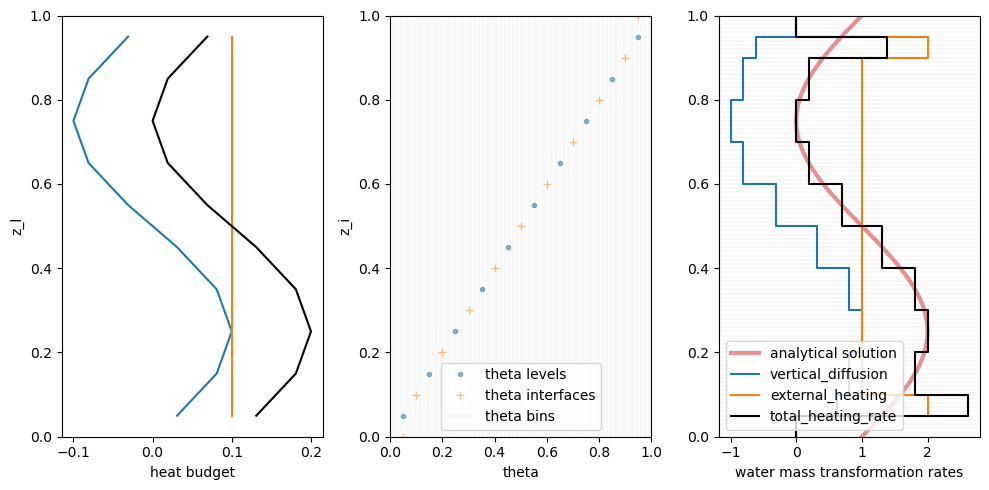

In [384]:
dz = 1.e-1
dlam = 1.e-2
bins = np.arange(0., 1.+dlam, dlam)

def lam_constant_stratification(z):
    return z

def exact_solution(lam):
    return np.sin(2*np.pi*lam) + 1.

ds = xr.Dataset()
ds = ds.assign_coords({
    'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
    'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
})
ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})

budget_dict = {'heat': {
    'lambda': 'theta',
    'lhs': {'tendency':'total_heating_rate'},
    'rhs': {
        'vertical_diffusion':'vertical_diffusion',
        'external_heating':'external_heating'
    }
}, 'salt': {'lambda':'salt', 'rhs': {}, 'lhs': {}}}

ds['vertical_diffusion'] = xr.DataArray(idealized_diffusion(ds.z_l), coords=(ds.z_l,))*ds.dz
ds['external_heating'] = xr.ones_like(ds.vertical_diffusion)*ds.dz
ds['total_heating_rate'] = ds['vertical_diffusion'] + ds['external_heating']

ds['theta'] = xr.DataArray(lam_constant_stratification(ds.z_l.data), coords=(ds.z_l,))

# expand to horizontal dimension and add grid metrics
ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

metrics = {
    ('X',): [], # X distances
    ('Y',): [], # Y distances
    ('Z',): ['dz'], # Z distances
    ('X', 'Y'): ['rA'] # Areas
}
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
    'Z': {'center': 'z_l', 'outer': 'z_i'},
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])

wmt = xwmt.WaterMassTransformations(ds, grid, budget_dict, cp=1., rho_ref=1.)
wmts = wmt.integrate_transformations("temperature", bins=bins, sum_components=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
for wmt in budget_dict['heat']['rhs'].values():
    ds[wmt].plot(y="z_l", label=wmt)
for wmt in budget_dict['heat']['lhs'].values():
    ds[wmt].plot(y="z_l", label=wmt, color="k")
plt.ylim(0, 1)
plt.xlabel("heat budget")
plt.title("")

plt.subplot(1,3,2)
lam = ds['theta']
lam.plot(y="z_l", linewidth=0., alpha=0.5, marker=".", label="theta levels")
lam_i = (
    grid.interp(lam, "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
    .rename(lam.name)
)
lam_i.plot(y="z_i", marker="+", linewidth=0., alpha=0.5, label="theta interfaces")
for b in bins:
    plt.axvline(b, color='k', alpha=0.15, lw=0.25)
plt.axvline(np.nan, color='k', alpha=0.15, lw=0.25, label="theta bins")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("")
plt.legend()
    
plt.subplot(1,3,3)
lam = wmts[wmt].theta
dlam_analytical = 1.e-5
lam_analytical = np.arange(dlam_analytical/2, 1., dlam_analytical)
plt.plot(exact_solution(lam_analytical), lam_analytical, color="C3", ls="-", label="analytical solution", alpha=0.5, lw=3)

for wmt in budget_dict['heat']['rhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, where="pre")
for wmt in budget_dict['heat']['lhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, color="k", where="pre")
for b in bins:
    plt.axhline(b, color='k', alpha=0.15, lw=0.25)
plt.ylim(0, 1)
    
plt.legend()
plt.ylim(0, 1)
plt.xlabel("water mass transformation rates")
plt.tight_layout()

### Effects of varying, vanishing, or negative stratification

In [388]:
dz = 1.e-3
dlam = 5.e-2
bins = np.arange(0., 1.+dlam, dlam)

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

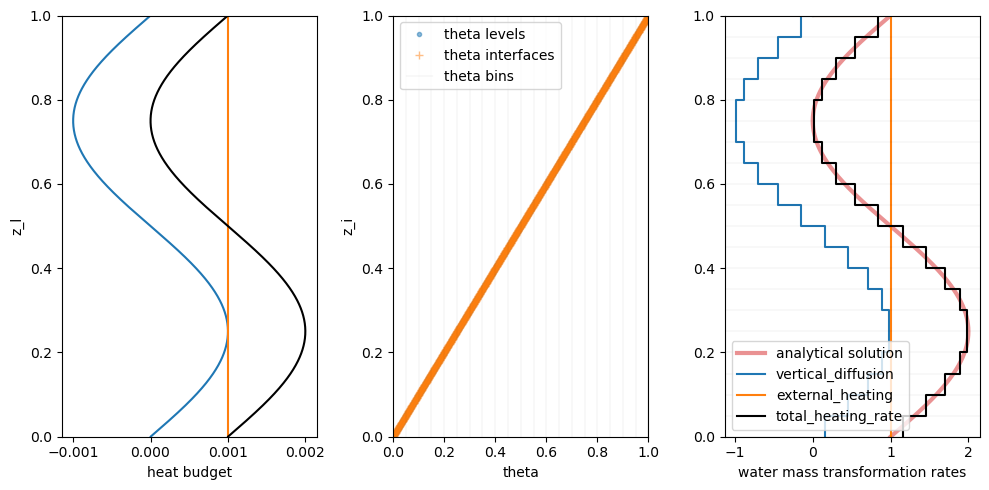

In [391]:
def lam_constant_stratification(z):
    return z

def exact_solution(lam):
    return np.sin(2*np.pi*lam) + 1.

ds = xr.Dataset()
ds = ds.assign_coords({
    'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
    'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
})
ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})

budget_dict = {'heat': {
    'lambda': 'theta',
    'lhs': {'tendency':'total_heating_rate'},
    'rhs': {
        'vertical_diffusion':'vertical_diffusion',
        'external_heating':'external_heating'
    }
}, 'salt': {'lambda':'salt', 'rhs': {}, 'lhs': {}}}

ds['vertical_diffusion'] = xr.DataArray(idealized_diffusion(ds.z_l), coords=(ds.z_l,))*ds.dz
ds['external_heating'] = xr.ones_like(ds.vertical_diffusion)*ds.dz
ds['total_heating_rate'] = ds['vertical_diffusion'] + ds['external_heating']

ds['theta'] = xr.DataArray(lam_constant_stratification(ds.z_l.data), coords=(ds.z_l,))

# expand to horizontal dimension and add grid metrics
ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

metrics = {
    ('X',): [], # X distances
    ('Y',): [], # Y distances
    ('Z',): ['dz'], # Z distances
    ('X', 'Y'): ['rA'] # Areas
}
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
    'Z': {'center': 'z_l', 'outer': 'z_i'},
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])

wmt = xwmt.WaterMassTransformations(ds, grid, budget_dict, cp=1., rho_ref=1.)
wmts = wmt.integrate_transformations("temperature", bins=bins, sum_components=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
for wmt in budget_dict['heat']['rhs'].values():
    ds[wmt].plot(y="z_l", label=wmt)
for wmt in budget_dict['heat']['lhs'].values():
    ds[wmt].plot(y="z_l", label=wmt, color="k")
plt.ylim(0, 1)
plt.xlabel("heat budget")
plt.title("")

plt.subplot(1,3,2)
lam = ds['theta']
lam.plot(y="z_l", linewidth=0., alpha=0.5, marker=".", label="theta levels")
lam_i = (
    grid.interp(lam, "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
    .rename(lam.name)
)
lam_i.plot(y="z_i", marker="+", linewidth=0., alpha=0.5, label="theta interfaces")
for b in bins:
    plt.axvline(b, color='k', alpha=0.15, lw=0.25)
plt.axvline(np.nan, color='k', alpha=0.15, lw=0.25, label="theta bins")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("")
plt.legend()
    
plt.subplot(1,3,3)
lam = wmts[wmt].theta
dlam_analytical = 1.e-5
lam_analytical = np.arange(dlam_analytical/2, 1., dlam_analytical)
plt.plot(exact_solution(lam_analytical), lam_analytical, color="C3", ls="-", label="analytical solution", alpha=0.5, lw=3)

for wmt in budget_dict['heat']['rhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, where="pre")
for wmt in budget_dict['heat']['lhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, color="k", where="pre")
for b in bins:
    plt.axhline(b, color='k', alpha=0.15, lw=0.25)
plt.ylim(0, 1)
    
plt.legend()
plt.ylim(0, 1)
plt.xlabel("water mass transformation rates")
plt.tight_layout()

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

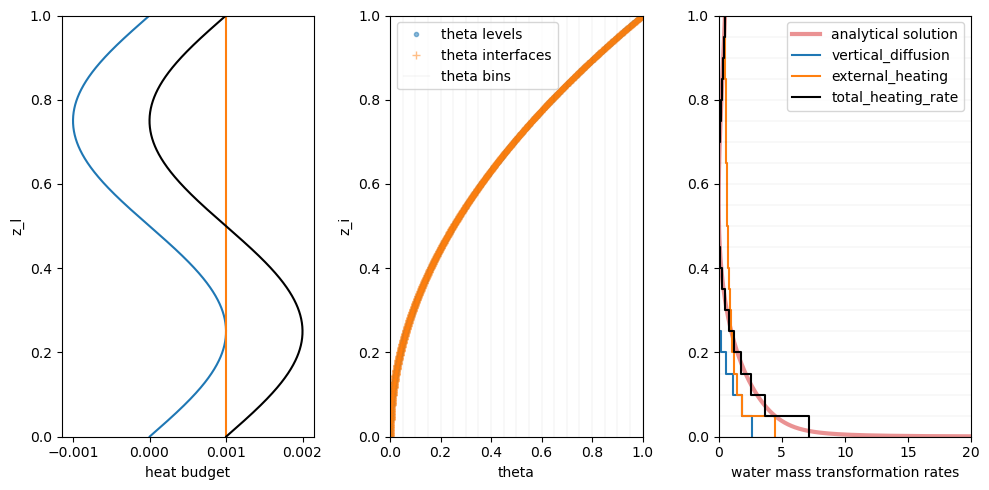

In [389]:
def lam_variable_stratification(z):
    return z**2
def exact_solution(lam):
    return (np.sin(2*np.pi*np.sqrt(lam)) + 1.)/(2*np.sqrt(lam))

ds = xr.Dataset()
ds = ds.assign_coords({
    'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
    'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
})
ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})

budget_dict = {'heat': {
    'lambda': 'theta',
    'lhs': {'tendency':'total_heating_rate'},
    'rhs': {
        'vertical_diffusion':'vertical_diffusion',
        'external_heating':'external_heating'
    }
}, 'salt': {'lambda':'salt', 'rhs': {}, 'lhs': {}}}
def idealized_diffusion(z):
    return np.sin(2*np.pi*z)
ds['vertical_diffusion'] = xr.DataArray(idealized_diffusion(ds.z_l), coords=(ds.z_l,))*ds.dz
ds['external_heating'] = xr.ones_like(ds.vertical_diffusion)*ds.dz
ds['total_heating_rate'] = ds['vertical_diffusion'] + ds['external_heating']

ds['theta'] = xr.DataArray(lam_variable_stratification(ds.z_l.data), coords=(ds.z_l,))

# expand to horizontal dimension and add grid metrics
ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

metrics = {
    ('X',): [], # X distances
    ('Y',): [], # Y distances
    ('Z',): ['dz'], # Z distances
    ('X', 'Y'): ['rA'] # Areas
}
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
    'Z': {'center': 'z_l', 'outer': 'z_i'},
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])

wmt = xwmt.WaterMassTransformations(ds, grid, budget_dict, cp=1., rho_ref=1.)
wmts = wmt.integrate_transformations("temperature", bins=bins, sum_components=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
for wmt in budget_dict['heat']['rhs'].values():
    ds[wmt].plot(y="z_l", label=wmt)
for wmt in budget_dict['heat']['lhs'].values():
    ds[wmt].plot(y="z_l", label=wmt, color="k")
plt.ylim(0, 1)
plt.xlabel("heat budget")
plt.title("")

plt.subplot(1,3,2)
lam = ds['theta']
lam.plot(y="z_l", linewidth=0., alpha=0.5, marker=".", label="theta levels")
lam_i = (
    grid.interp(lam, "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
    .rename(lam.name)
)
lam_i.plot(y="z_i", marker="+", linewidth=0., alpha=0.5, label="theta interfaces")
for b in bins:
    plt.axvline(b, color='k', alpha=0.15, lw=0.25)
plt.axvline(np.nan, color='k', alpha=0.15, lw=0.25, label="theta bins")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("")
plt.legend()
    
plt.subplot(1,3,3)
lam = wmts[wmt].theta
dlam_analytical = 1.e-5
lam_analytical = np.arange(dlam_analytical/2, 1., dlam_analytical)
plt.plot(exact_solution(lam_analytical), lam_analytical, color="C3", ls="-", label="analytical solution", alpha=0.5, lw=3)

for wmt in budget_dict['heat']['rhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, where="pre")
for wmt in budget_dict['heat']['lhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, color="k", where="pre")
for b in bins:
    plt.axhline(b, color='k', alpha=0.15, lw=0.25)
    
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 20)
plt.xlabel("water mass transformation rates")
plt.tight_layout()

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

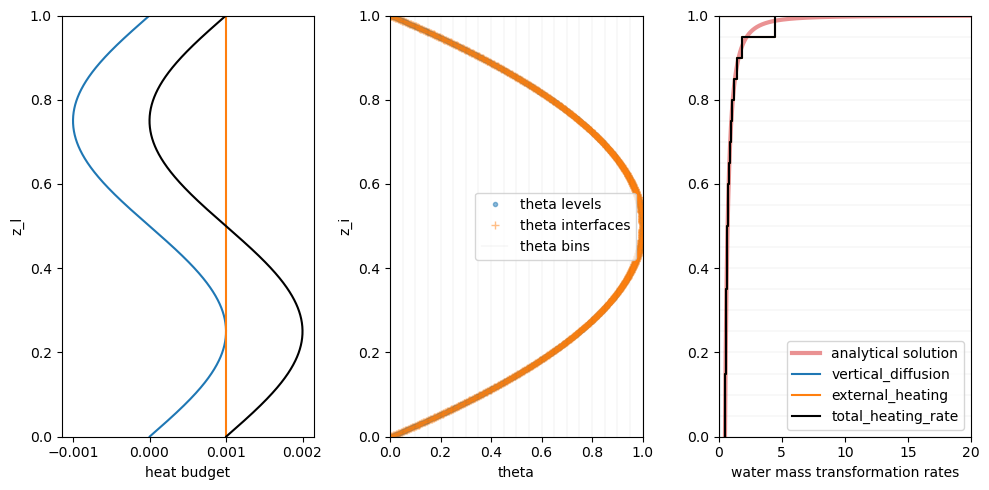

In [390]:
def lam_nonmonotic_stratification(z):
    return 1 - (2*z - 1)**2

def exact_solution(lam):
    return 1/(2*np.sqrt(1-lam))

ds = xr.Dataset()
ds = ds.assign_coords({
    'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
    'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
})
ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})

budget_dict = {'heat': {
    'lambda': 'theta',
    'lhs': {'tendency':'total_heating_rate'},
    'rhs': {
        'vertical_diffusion':'vertical_diffusion',
        'external_heating':'external_heating'
    }
}, 'salt': {'lambda':'salt', 'rhs': {}, 'lhs': {}}}
def idealized_diffusion(z):
    return np.sin(2*np.pi*z)
ds['vertical_diffusion'] = xr.DataArray(idealized_diffusion(ds.z_l), coords=(ds.z_l,))*ds.dz
ds['external_heating'] = xr.ones_like(ds.vertical_diffusion)*ds.dz
ds['total_heating_rate'] = ds['vertical_diffusion'] + ds['external_heating']

ds['theta'] = xr.DataArray(lam_nonmonotic_stratification(ds.z_l.data), coords=(ds.z_l,))

# expand to horizontal dimension and add grid metrics
ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

metrics = {
    ('X',): [], # X distances
    ('Y',): [], # Y distances
    ('Z',): ['dz'], # Z distances
    ('X', 'Y'): ['rA'] # Areas
}
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
    'Z': {'center': 'z_l', 'outer': 'z_i'},
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])

wmt = xwmt.WaterMassTransformations(ds, grid, budget_dict, cp=1., rho_ref=1.)
wmts = wmt.integrate_transformations("temperature", bins=bins, sum_components=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
for wmt in budget_dict['heat']['rhs'].values():
    ds[wmt].plot(y="z_l", label=wmt)
for wmt in budget_dict['heat']['lhs'].values():
    ds[wmt].plot(y="z_l", label=wmt, color="k")
plt.ylim(0, 1)
plt.xlabel("heat budget")
plt.title("")

plt.subplot(1,3,2)
lam = ds['theta']
lam.plot(y="z_l", linewidth=0., alpha=0.5, marker=".", label="theta levels")
lam_i = (
    grid.interp(lam, "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
    .rename(lam.name)
)
lam_i.plot(y="z_i", marker="+", linewidth=0., alpha=0.5, label="theta interfaces")
for b in bins:
    plt.axvline(b, color='k', alpha=0.15, lw=0.25)
plt.axvline(np.nan, color='k', alpha=0.15, lw=0.25, label="theta bins")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("")
plt.legend()
    
plt.subplot(1,3,3)
lam = wmts[wmt].theta
dlam_analytical = 1.e-5
lam_analytical = np.arange(dlam_analytical/2, 1., dlam_analytical)
plt.plot(exact_solution(lam_analytical), lam_analytical, color="C3", ls="-", label="analytical solution", alpha=0.5, lw=3)

for wmt in budget_dict['heat']['rhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, where="pre")
for wmt in budget_dict['heat']['lhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, color="k", where="pre")
for b in bins:
    plt.axhline(b, color='k', alpha=0.15, lw=0.25)
plt.ylim(0, 1)
    
plt.legend(loc="lower right")
plt.ylim(0, 1)
plt.xlim(0, 20)
plt.xlabel("water mass transformation rates")
plt.tight_layout()

### Convergence of results as grid spacing decreases

In [364]:
dz = 1.e-4
dlam = 1.e-4
bins = np.arange(0., 1.+dlam, dlam)

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

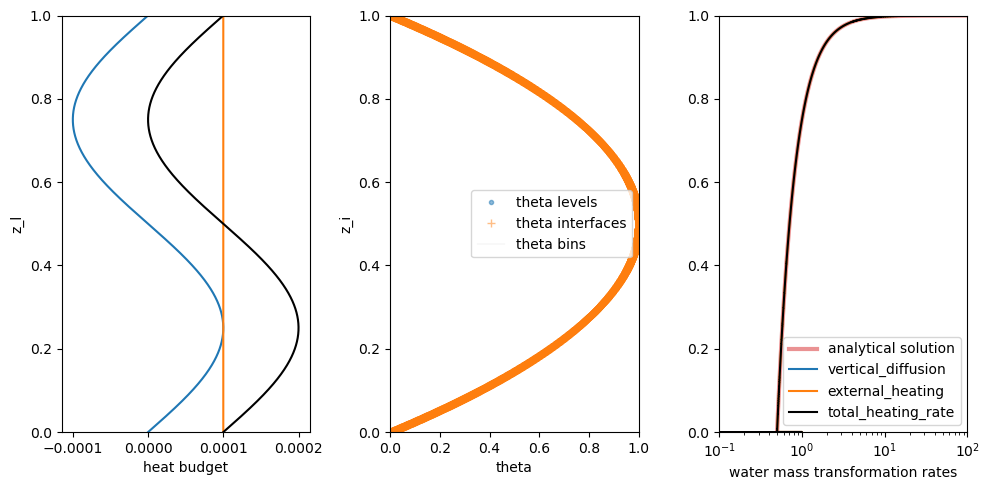

In [365]:
def lam_nonmonotic_stratification(z):
    return 1 - (2*z - 1)**2

def exact_solution(lam):
    return 1/(2*np.sqrt(1-lam))

ds = xr.Dataset()
ds = ds.assign_coords({
    'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
    'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
})
ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})

budget_dict = {'heat': {
    'lambda': 'theta',
    'lhs': {'tendency':'total_heating_rate'},
    'rhs': {
        'vertical_diffusion':'vertical_diffusion',
        'external_heating':'external_heating'
    }
}, 'salt': {'lambda':'salt', 'rhs': {}, 'lhs': {}}}
def idealized_diffusion(z):
    return np.sin(2*np.pi*z)
ds['vertical_diffusion'] = xr.DataArray(idealized_diffusion(ds.z_l), coords=(ds.z_l,))*ds.dz
ds['external_heating'] = xr.ones_like(ds.vertical_diffusion)*ds.dz
ds['total_heating_rate'] = ds['vertical_diffusion'] + ds['external_heating']

ds['theta'] = xr.DataArray(lam_nonmonotic_stratification(ds.z_l.data), coords=(ds.z_l,))

# expand to horizontal dimension and add grid metrics
ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

metrics = {
    ('X',): [], # X distances
    ('Y',): [], # Y distances
    ('Z',): ['dz'], # Z distances
    ('X', 'Y'): ['rA'] # Areas
}
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
    'Z': {'center': 'z_l', 'outer': 'z_i'},
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])

wmt = xwmt.WaterMassTransformations(ds, grid, budget_dict, cp=1., rho_ref=1.)
wmts = wmt.integrate_transformations("temperature", bins=bins, sum_components=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
for wmt in budget_dict['heat']['rhs'].values():
    ds[wmt].plot(y="z_l", label=wmt)
for wmt in budget_dict['heat']['lhs'].values():
    ds[wmt].plot(y="z_l", label=wmt, color="k")
plt.ylim(0, 1)
plt.xlabel("heat budget")
plt.title("")

plt.subplot(1,3,2)
lam = ds['theta']
lam.plot(y="z_l", linewidth=0., alpha=0.5, marker=".", label="theta levels")
lam_i = (
    grid.interp(lam, "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
    .rename(lam.name)
)
lam_i.plot(y="z_i", marker="+", linewidth=0., alpha=0.5, label="theta interfaces")
plt.axvline(np.nan, color='k', alpha=0.15, lw=0.25, label="theta bins")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("")
plt.legend()
    
plt.subplot(1,3,3)
lam = wmts[wmt].theta
dlam_analytical = 1.e-5
lam_analytical = np.arange(dlam_analytical/2, 1., dlam_analytical)
plt.plot(exact_solution(lam_analytical), lam_analytical, color="C3", ls="-", label="analytical solution", lw=3, alpha=0.5)

for wmt in budget_dict['heat']['rhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, where="pre")
for wmt in budget_dict['heat']['lhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, color="k", where="pre")
plt.ylim(0, 1)
    
plt.legend()
plt.ylim(0, 1)
plt.xlim(0.1, 100)
plt.xscale("log")
plt.xlabel("water mass transformation rates")
plt.tight_layout()

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

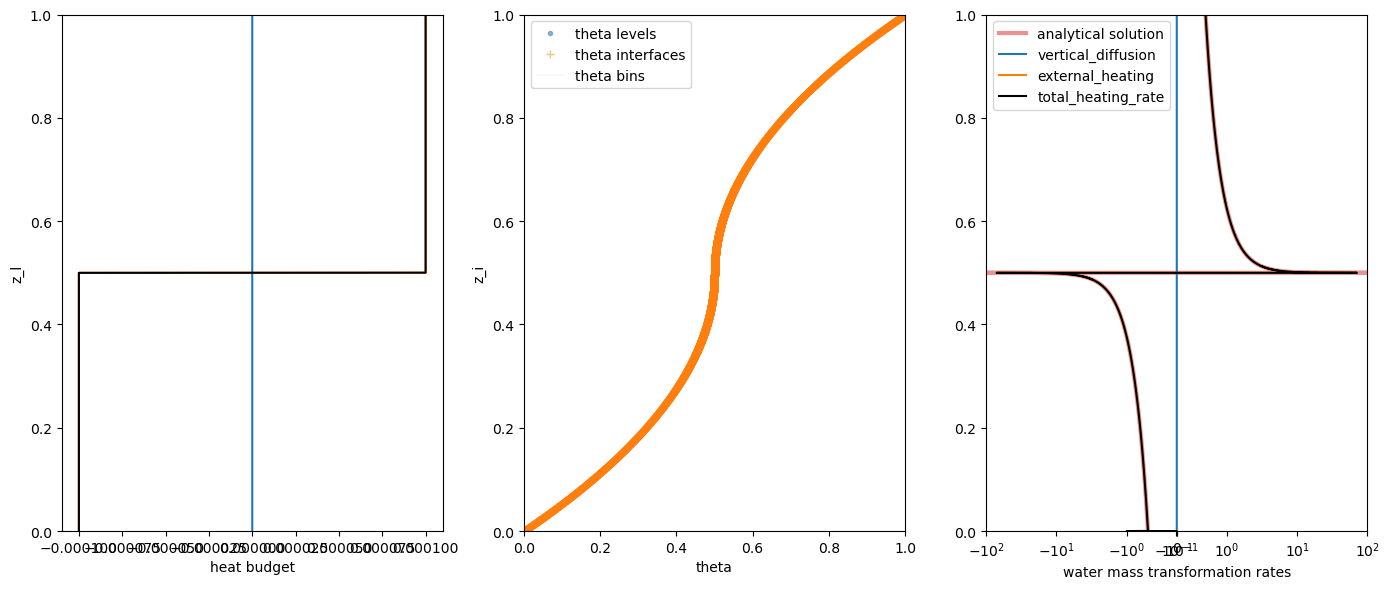

In [366]:
def lam_vanishing_stratification(z):
    sign = 2*np.float64(z>0.5)-1
    return (1 + sign*(2*z - 1)**2)/2.

def exact_solution(lam):
    sign = 2*np.float64(lam>0.5)-1
    return sign/(2*np.sqrt(sign*(2*lam-1)))

ds = xr.Dataset()
ds = ds.assign_coords({
    'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
    'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
})
ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})

budget_dict = {'heat': {
    'lambda': 'theta',
    'lhs': {'tendency':'total_heating_rate'},
    'rhs': {
        'vertical_diffusion':'vertical_diffusion',
        'external_heating':'external_heating'
    }
}, 'salt': {'lambda':'salt', 'rhs': {}, 'lhs': {}}}
def idealized_diffusion(z):
    return np.sin(2*np.pi*z)
ds['vertical_diffusion'] = 0.*xr.DataArray(idealized_diffusion(ds.z_l), coords=(ds.z_l,))*ds.dz
ds['external_heating'] = xr.ones_like(ds.vertical_diffusion)*ds.dz * (2*np.float64(ds.z_l>0.5)-1)
ds['total_heating_rate'] = ds['vertical_diffusion'] + ds['external_heating']

ds['theta'] = xr.DataArray(lam_vanishing_stratification(ds.z_l.data), coords=(ds.z_l,))

# expand to horizontal dimension and add grid metrics
ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

metrics = {
    ('X',): [], # X distances
    ('Y',): [], # Y distances
    ('Z',): ['dz'], # Z distances
    ('X', 'Y'): ['rA'] # Areas
}
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
    'Z': {'center': 'z_l', 'outer': 'z_i'},
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])

wmt = xwmt.WaterMassTransformations(ds, grid, budget_dict, cp=1., rho_ref=1.)
wmts = wmt.integrate_transformations("temperature", bins=bins, sum_components=False)

plt.figure(figsize=(14, 6))
plt.subplot(1,3,1)
for wmt in budget_dict['heat']['rhs'].values():
    ds[wmt].plot(y="z_l", label=wmt)
for wmt in budget_dict['heat']['lhs'].values():
    ds[wmt].plot(y="z_l", label=wmt, color="k")
plt.ylim(0, 1)
plt.xlabel("heat budget")
plt.title("")

plt.subplot(1,3,2)
lam = ds['theta']
lam.plot(y="z_l", linewidth=0., alpha=0.5, marker=".", label="theta levels")
lam_i = (
    grid.interp(lam, "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
    .rename(lam.name)
)
lam_i.plot(y="z_i", marker="+", linewidth=0., alpha=0.5, label="theta interfaces")
plt.axvline(np.nan, color='k', alpha=0.15, lw=0.25, label="theta bins")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("")
plt.legend()
    
plt.subplot(1,3,3)
lam = wmts[wmt].theta
dlam_analytical = 1.e-5
lam_analytical = np.arange(dlam_analytical/2, 1., dlam_analytical)
plt.plot(exact_solution(lam_analytical), lam_analytical, color="C3", ls="-", label="analytical solution", lw=3, alpha=0.5)

for wmt in budget_dict['heat']['rhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, where="pre")
for wmt in budget_dict['heat']['lhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, color="k", where="pre")

plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.xscale("symlog", linthresh=0.2, linscale=0.01)
plt.xlim(-100, 100)
plt.xlabel("water mass transformation rates")
plt.tight_layout()

## Same thing but constant stratification

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

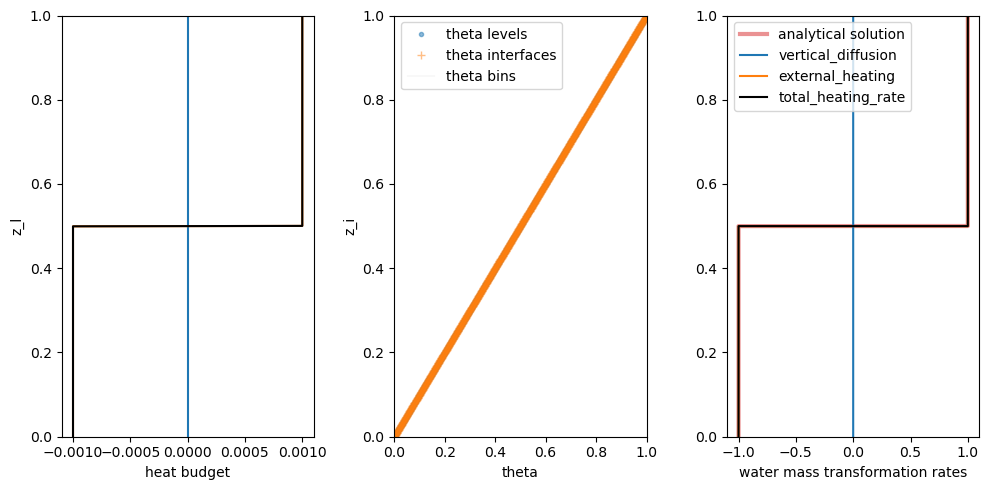

In [367]:
dz = 1.e-3
dlam = 1.e-3
bins = np.arange(0., 1.+dlam, dlam)

def exact_solution(lam):
    return (2*(lam>0.5)-1)

ds = xr.Dataset()
ds = ds.assign_coords({
    'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
    'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
})
ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})

budget_dict = {'heat': {
    'lambda': 'theta',
    'lhs': {'tendency':'total_heating_rate'},
    'rhs': {
        'vertical_diffusion':'vertical_diffusion',
        'external_heating':'external_heating'
    }
}, 'salt': {'lambda':'salt', 'rhs': {}, 'lhs': {}}}
def idealized_diffusion(z):
    return np.sin(2*np.pi*z)
ds['vertical_diffusion'] = 0.*xr.DataArray(idealized_diffusion(ds.z_l), coords=(ds.z_l,))*ds.dz
ds['external_heating'] = xr.ones_like(ds.vertical_diffusion)*ds.dz * (2*np.float64(ds.z_l>0.5)-1)
ds['total_heating_rate'] = ds['vertical_diffusion'] + ds['external_heating']

ds['theta'] = xr.DataArray(lam_constant_stratification(ds.z_l.data), coords=(ds.z_l,))

# expand to horizontal dimension and add grid metrics
ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

metrics = {
    ('X',): [], # X distances
    ('Y',): [], # Y distances
    ('Z',): ['dz'], # Z distances
    ('X', 'Y'): ['rA'] # Areas
}
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
    'Z': {'center': 'z_l', 'outer': 'z_i'},
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])

wmt = xwmt.WaterMassTransformations(ds, grid, budget_dict, cp=1., rho_ref=1.)
wmts = wmt.integrate_transformations("temperature", bins=bins, sum_components=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
for wmt in budget_dict['heat']['rhs'].values():
    ds[wmt].plot(y="z_l", label=wmt)
for wmt in budget_dict['heat']['lhs'].values():
    ds[wmt].plot(y="z_l", label=wmt, color="k")
plt.ylim(0, 1)
plt.xlabel("heat budget")
plt.title("")

plt.subplot(1,3,2)
lam = ds['theta']
lam.plot(y="z_l", linewidth=0., alpha=0.5, marker=".", label="theta levels")
lam_i = (
    grid.interp(lam, "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
    .rename(lam.name)
)
lam_i.plot(y="z_i", marker="+", linewidth=0., alpha=0.5, label="theta interfaces")
plt.axvline(np.nan, color='k', alpha=0.15, lw=0.25, label="theta bins")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("")
plt.legend()
    
plt.subplot(1,3,3)
lam = wmts[wmt].theta
dlam_analytical = 1.e-5
lam_analytical = np.arange(dlam_analytical/2, 1., dlam_analytical)
plt.plot(exact_solution(lam_analytical), lam_analytical, color="C3", ls="-", label="analytical solution", alpha=0.5, lw=3)

for wmt in budget_dict['heat']['rhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, where="pre")
for wmt in budget_dict['heat']['lhs'].values():
    plt.step(np.append(wmts[wmt], [0]), bins, label=wmt, color="k", where="pre")
plt.ylim(0, 1)
    
plt.legend()
plt.ylim(0, 1)
plt.xlabel("water mass transformation rates")
plt.tight_layout()